In [ ]:
Objective: To construct a co-occurrence matrix from top 2k and 5k words respectively from tf-idf. Then, finding the matrices
           using Truncated SVD, U, Σ, V and then appying K-Means++ on different values of 'K' and take insights from the 
           respective clusters and plot WordCloud for each Cluster.

In [30]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

Data Cleaning: Deduplication



In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#final=final.drop_duplicates(subset={"UserId","ProductId","Time"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [10]:
# find sentences containing HTML tags
import re

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
import re
# nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'again', 'its', 'her', 'out', 'we', 'down', 'than', 'isn', "wouldn't", 'mustn', "aren't", "wasn't", "that'll", 'just', 'don', 'mightn', 'my', "shan't", 'wasn', "isn't", 'up', 'him', 'this', 'were', 'because', 'their', 'been', 'above', "you'll", 'them', 'below', 'doing', 'herself', 'before', 'on', 'how', 'until', 'and', "hadn't", 'doesn', 'himself', 'which', 'they', 'some', 'to', 'into', 'all', 'a', 'only', 'yourselves', 'about', 're', 'ours', 'had', 'be', 'more', 'that', 'i', 'yourself', 'weren', 'can', "don't", "haven't", 'you', 'do', 'if', 'there', 'are', 'not', 'from', 'when', 'these', 'where', 'hasn', 'at', 'in', 'by', 'other', 'while', 'why', 'haven', 'over', 'itself', 'most', 'through', 'both', 'so', 'myself', 's', 'shan', 'themselves', 'few', 'now', 'his', "you'd", "mustn't", 'any', 'same', 'he', 'will', 'was', 't', 'hers', 'having', 'aren', 'then', 'who', 'of', 'me', 'did', 'under', 'wouldn', 'ain', 'has', "you've", 'am', 'ma', 'shouldn', 'what', 'each', 'no', 'very', 'does', 

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
del final['Score'] # delete the 'Score' attribute 

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [15]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [16]:
final_df = pd.DataFrame(final) # storing a table in dataframe

In [17]:
random_final = final_df.sample(n=10000) # taking a sample of 10000 rows
random_final

Id   ProductId          UserId  \
161103  174648  B000F40966  A1JCUUA8L74DKI   
163366  177129  B004FEJ968  A339F4I8GBN3H3   
426250  460980  B006LMIPC6  A2YJVPZJZV8T0N   
389959  421642  B002VLZ8D0  A1P8G51NJENCA2   
246082  266818  B0010OQQ2Q  A29RO8ZY8JAH6G   
7474      8164  B001HTR4WA  A350QGC1FG0QAE   
188919  204883  B0000SWLFO   A5OUCPIAM0ZX5   
28020    30558  B006WJHOX4  A1LWU81HXK2NNG   
404515  437425  B008J1UAZ2  A295E6ZJKW4V1W   
102272  111086  B0014WYXYW  A3VEXXZ7M8KDSJ   
389181  420817  B0002I0GUY  A2S9YX8PTJIAPO   
98067   106537  B00423UVJQ   A8QMFFM2T6EPX   
436419  471922  B0000UC7RE  A1UFETTJMW6H63   
435264  470691  B001ELL60W   AFBUH08GNWREI   
259762  281594  B007RTR9DS  A2G00E835L0AYB   
381429  412426  B000GZUAFE  A3GFVYQ9ZRQIXQ   
513406  555099  B002DW4R9S  A3BMPATN9C6RQS   
359590  388946  B001W14THQ   A3FUFARV0VGY2   
25151    27470  B0007OVWL0  A3HPAWABUZTZ3Y   
517881  559901  B000V9SMXC   AVTEBS6EXU2PD   
42837    46604  B002GJ9JWS  A328X3XDGFFYIQ   
211761  229541  B004V0NWA0  A3TXXD59X0LG4R   
294681  319223  B003CFX90S  A17ZFRYEMDHCQB   
238319  258551  B000WFRQ96  A2DNTJYRT6XRU4   
18180    19810  B0030VBRIU   ATIHDHZYNQ0EI   
324449  351165  B007794PBM  A3LSLLR3OAJI7Y   
121206  131393  B000VHZ84A  A3T0XNCN34YSWE   
287384  311320  B000WFNO6A  A2R8Z9CEGYX31N   
342284  370298  B000ZSZ5S4   A2TMY1YEB4TA6   
482846  522087  B003L7DFQA   AC59TWZZKTPKL   
...        ...         ...             ...   
161137  174684  B007RTR8T8   AOOQWI1GV0BWM   
284987  308737  B000F3S6JY  A3QH2KGOXWH34Z   
201453  218302  B0046IEMOM  A2AJYFRM2Q4CIA   
32534    35410  B000GW46D4   A5XGP2YYCGMTX   
432621  467853  B000EVOQNC  A3PZ4AXTY9J1DZ   
143419  155632  B00474D5DY  A27RKDM7JVE346   
444857  481001  B001HTL26O  A28KYEGQZWHWPK   
469097  507243  B000GKEYT2  A2GA55P7WGHJCP   
376036  406609  B001EQ4J56  A2UYVT2L25H0TN   
76978    83746  B005ZBZLT4   ACX4THN5ILWRR   
415891  449765  B001P75CKK  A3BMNVZJLOCSEO   
110526  119940  B0001KL70Q  A3E0CCSG5MEHJK   
348229  376672  B004NSH6O8  A11T807LX2EF00   
405205  438183  B000FFIEL2  A333VTQE0G2W59   
141302  153334  B008ADQS9Q  A3OGYXV9S7MJHM   
368612  398538  B0025UC2DQ  A1HAE81PLVGK2Y   
129799  140884  B001EO69NI  A2DC6ICU1UK3FG   
488462  528188  B004981W5G  A2K6IW2AHIZCKC   
164590  178500  B001BBYCW4  A3UXOJO9GESSTT   
439348  475113  B00771R6QQ  A1ZX69VD8SZX80   
424401  458995  B0040Q0TPQ  A1XNMF77GJ8V8S   
222755  241551  B000PJF7BS  A2TXJF7AR8OHAE   
49891    54178  B001D0FT0C   AUZYSGOKXE54N   
370578  400737  B0007SNZE8  A2108FCM8HA7I3   
295761  320374  B003Z6W32E   ADSFKIX44X8JV   
142897  155088  B004QXF0GQ  A2JLK5VGGKHHL4   
498037  538456  B001ICW5IE  A16JIQC2COGZCM   
318940  345279  B001KWFK0C  A3U139EU4OP03A   
78562    85439  B002DHTWNO   A1NOWNYJ1DRE6   
327622  354601  B000LKU3A6  A29I0OB6DHLAR0   

                                             ProfileName  \
161103  Bea Knight Johnson "bea knight-johnson, tea m...   
163366         LaughingLion "I am Lion, read me review!"   
426250                      Melissa A. Brown "teachgirl"   
389959  RescueGirl "Yoga to the Rescue: author/Illust...   
246082                                     J. P. Rissing   
7474                                                 Joy   
188919            Simply Dolling "&#34;movie Lover&#34;"   
28020                                               Anne   
404515                                        Dan Stingl   
102272               Michael R. Wurster "Pentaholocaust"   
389181                                             Peggy   
98067                               Leslie Anne Lawrence   
436419                                  Shonta Alexander   
435264                                                KC   
259762                                           Shantel   
381429                                    Shannon Morris   
513406                                               Dan   
359590                                             aunty   
25151              

 TF-IDF 

In [28]:
# taking top 2000 words according to tfidf
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(random_final['CleanedText'].values)

# pick top 2000 top tf-idf words 
indices1 = np.argsort(tf_idf_vect.idf_)[::-1]
features1 = tf_idf_vect.get_feature_names()

top_n1 = [features1[i] for i in indices1[:2000]]
indices_top1 = np.argsort(top_n1)[::-1]


In [19]:
n1 = set(top_n1)
f1 = set(features1)
new_set = f1-n1
new_list = list(new_set)
a = np.array((new_list))
D_tr = final_tf_idf.toarray()

In [21]:
for i in range(0, a.size):
    D_tr = np.delete(D_tr, a.shape, axis=1)

In [23]:
from scipy import sparse

# converting into sparse matrix
Sc_tr = sparse.csr_matrix(D_tr)

In [24]:
type(Sc_tr)

scipy.sparse.csr.csr_matrix

In [25]:
final_tf_idf = Sc_tr

In [29]:
# shape of tf-idf
final_tf_idf.get_shape()


(10000, 2000)

In [20]:
# Creating a co-occurrence matrix 
final_tf_idf[final_tf_idf > 0] = 1 # to remove word-co-occurrence within each line
final_tf = (final_tf_idf.T * final_tf_idf)
final_tf.setdiag(0)  # set diagonal elements to be zero as their count will be zero with respect to the same element

In [21]:
final_tf # type of co-occurrence matrix

<2000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2098284 stored elements in Compressed Sparse Column format>

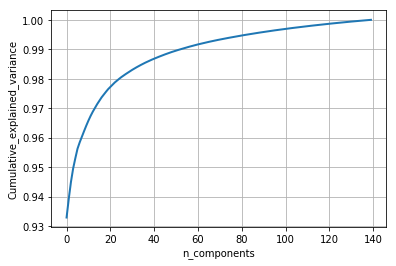

In [22]:
'''
Plotting a CDF on number of components and cumulative_variance_explained to choose the best value of number of components 
such that maximum varince is explained.

'''

from sklearn.decomposition import TruncatedSVD

svd_tf = TruncatedSVD(n_components = 140)
svd_data_tf = svd_tf.fit_transform(final_tf)

percentage_var_explained_tf = svd_tf.explained_variance_ / np.sum(svd_tf.explained_variance_);

cum_var_explained_tf = np.cumsum(percentage_var_explained_tf)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained_tf, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# If we take 130-dimensions, approx. 98% of variance is explained.

In [23]:
from sklearn.utils.extmath import randomized_svd

# matrix factorization of X = U Σ V.T
U, Sigma, VT = randomized_svd(final_tf, 
                              n_components=130,
                              n_iter=7,
                              random_state=42)

In [24]:
# Standardizing the data with mean=0 and std.dev=1 of u
from sklearn.preprocessing import StandardScaler
standardized_data_tf_idf = StandardScaler().fit_transform(U)
print(standardized_data_tf_idf.shape)

(2000, 130)


In [25]:
X_tf = np.array(standardized_data_tf_idf) # storing the values after standardization in a numpy array

In [26]:
from sklearn.cluster import KMeans

# Clustering using Kmeans++ for 50 clusters 
kmeans_tf = KMeans(n_clusters=50, random_state=42, n_init=50, n_jobs=-1)
kmeans_tf.fit(X_tf)

    



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=50, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [27]:
kmeans_tf.predict(X_tf) # labels of clusters

array([4, 4, 4, ..., 4, 4, 4], dtype=int32)

In [28]:
kmeans_tf.cluster_centers_ # print cluster centers

array([[ 9.41764206e-01,  2.15239596e-03,  1.00766334e-02, ...,
         1.08425950e-01,  7.53567243e-01,  4.32836993e-01],
       [ 1.85349123e+00, -2.15924308e-01,  1.55828713e-01, ...,
        -9.18332601e-01, -6.04332796e-01,  9.80274539e-01],
       [ 8.47443831e+00,  7.44422713e-03,  1.76033241e+00, ...,
        -1.17411111e+00,  2.99227577e-01,  6.89021238e-01],
       ...,
       [ 4.22075540e+00, -6.96849396e+00,  3.69430706e-01, ...,
         2.36967900e-01, -1.55896098e+00, -1.72644808e-01],
       [ 2.63221971e+00, -2.13133923e+00,  1.04275248e-02, ...,
        -2.75093869e+00,  5.31007164e-01,  3.51715575e+00],
       [ 2.09779767e+00,  6.95986801e+00, -1.75633302e-01, ...,
        -2.80645371e-01,  1.53573609e-01, -9.47976585e-02]])

Cluster 0:Word Cloud for KMeans Cluster: 0


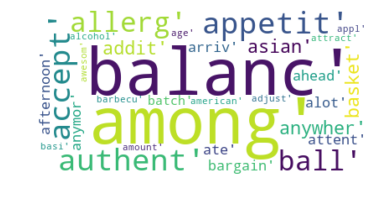

Cluster 1:Word Cloud for KMeans Cluster: 1


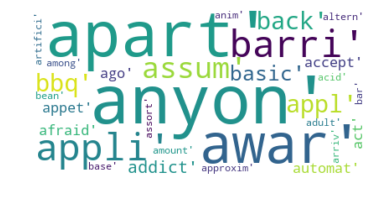

Cluster 2:Word Cloud for KMeans Cluster: 2


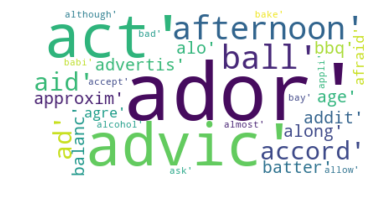

Cluster 3:Word Cloud for KMeans Cluster: 3


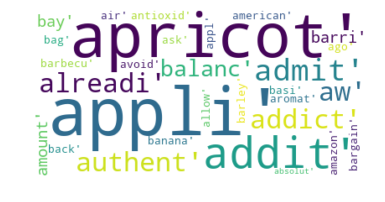

Cluster 4:Word Cloud for KMeans Cluster: 4


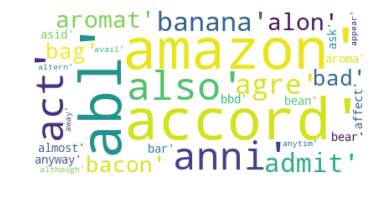

Cluster 5:Word Cloud for KMeans Cluster: 5


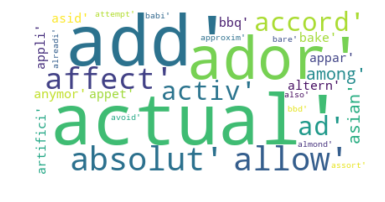

Cluster 6:Word Cloud for KMeans Cluster: 6


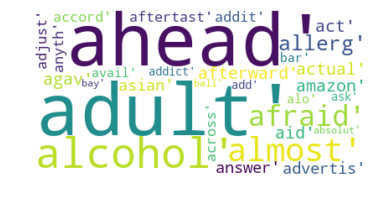

Cluster 7:Word Cloud for KMeans Cluster: 7


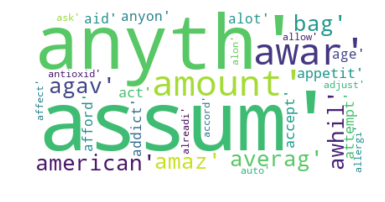

Cluster 8:Word Cloud for KMeans Cluster: 8


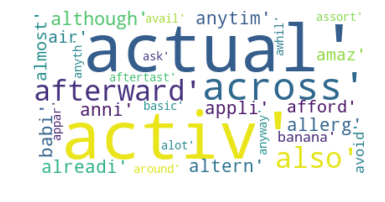

Cluster 9:Word Cloud for KMeans Cluster: 9


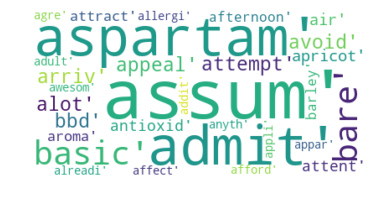

In [52]:
from wordcloud import WordCloud, STOPWORDS

stopwords_t = set(STOPWORDS)

centroids = kmeans_tf.cluster_centers_.argsort() # function for printing top 30 feature names with each cluster

terms = tf_idf_vect.get_feature_names()

list1 = []

for i in range(10):
    print("Cluster %d:" % i, end='')
    for j in centroids[i, :30]:
        list1.append(terms[j])
    wc = WordCloud(background_color="white", max_words=len(str(list1)), stopwords=stopwords_t)
    wc.generate(str(list1))
    print("Word Cloud for KMeans Cluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    list1.clear()

In [53]:
from sklearn.cluster import KMeans

# Clustering using Kmeans++ for 30 clusters 
kmeans_tf = KMeans(n_clusters=30, random_state=42, n_init=40, n_jobs=-1)
kmeans_tf.fit(X_tf)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=40, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [54]:
kmeans_tf.predict(X_tf) # labels of clusters

array([ 1, 26,  1, ..., 26, 26, 26], dtype=int32)

In [55]:
kmeans_tf.cluster_centers_ # print cluster centers

array([[ 0.70524317, -2.25005238,  0.12236495, ...,  3.20186095,
         0.77567915,  0.06882566],
       [ 0.75771404, -0.34930376,  0.04515328, ...,  0.18945237,
        -0.62704159,  0.30636031],
       [ 7.84712496, 10.61065004,  2.09366836, ...,  0.28313166,
        -0.26390115, -0.24408033],
       ...,
       [ 2.65618684, -0.19315479, -0.13916813, ...,  2.05053487,
         1.23846523, -3.12046396],
       [ 4.05605147, -7.63852255,  1.58895978, ..., -0.3098937 ,
         2.18786272, -2.46892632],
       [ 2.96381464,  9.38394821, -0.13944774, ..., -0.7655695 ,
        -0.14032026, -0.31823259]])

Cluster 0:Word Cloud for KMeans Cluster: 0


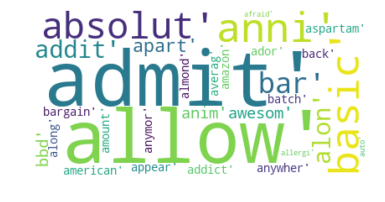

Cluster 1:Word Cloud for KMeans Cluster: 1


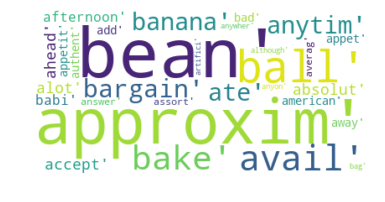

Cluster 2:Word Cloud for KMeans Cluster: 2


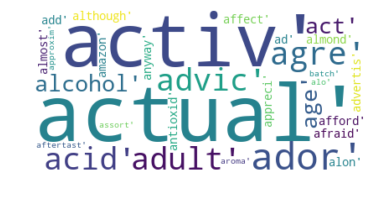

Cluster 3:Word Cloud for KMeans Cluster: 3


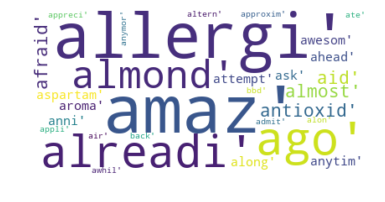

Cluster 4:Word Cloud for KMeans Cluster: 4


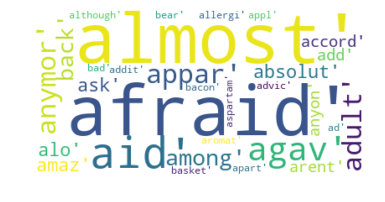

Cluster 5:Word Cloud for KMeans Cluster: 5


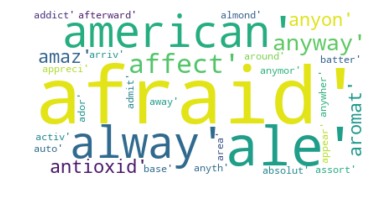

Cluster 6:Word Cloud for KMeans Cluster: 6


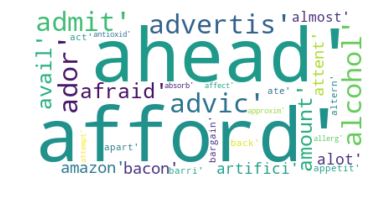

Cluster 7:Word Cloud for KMeans Cluster: 7


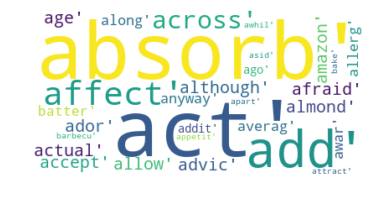

Cluster 8:Word Cloud for KMeans Cluster: 8


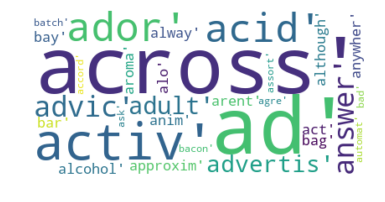

Cluster 9:Word Cloud for KMeans Cluster: 9


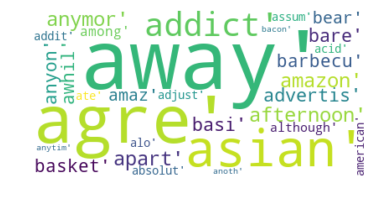

Cluster 10:Word Cloud for KMeans Cluster: 10


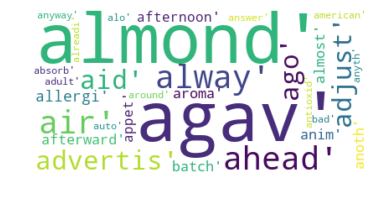

Cluster 11:Word Cloud for KMeans Cluster: 11


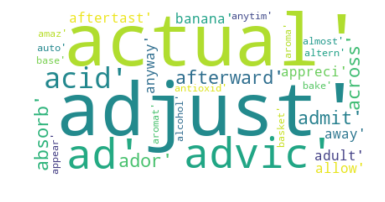

Cluster 12:Word Cloud for KMeans Cluster: 12


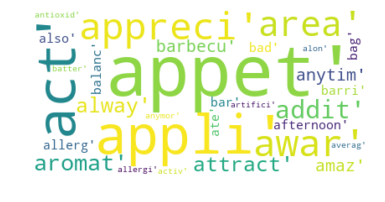

Cluster 13:Word Cloud for KMeans Cluster: 13


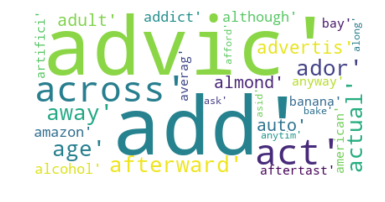

Cluster 14:Word Cloud for KMeans Cluster: 14


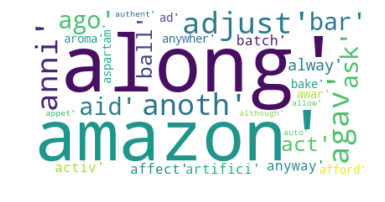

Cluster 15:Word Cloud for KMeans Cluster: 15


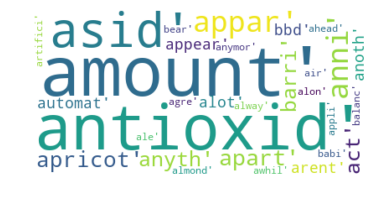

Cluster 16:Word Cloud for KMeans Cluster: 16


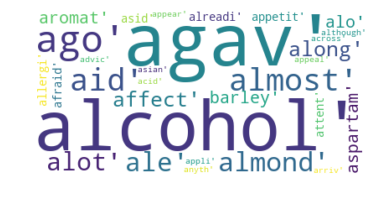

Cluster 17:Word Cloud for KMeans Cluster: 17


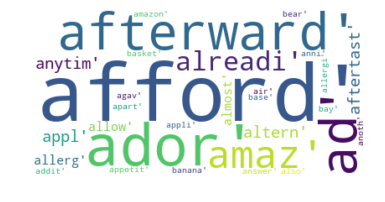

Cluster 18:Word Cloud for KMeans Cluster: 18


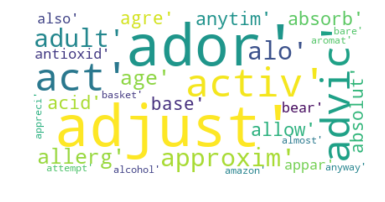

Cluster 19:Word Cloud for KMeans Cluster: 19


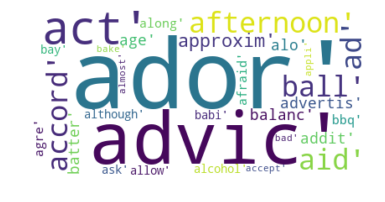

Cluster 20:Word Cloud for KMeans Cluster: 20


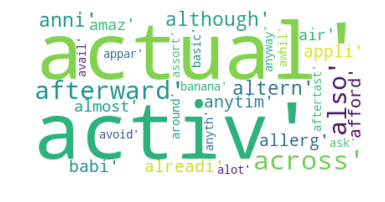

Cluster 21:Word Cloud for KMeans Cluster: 21


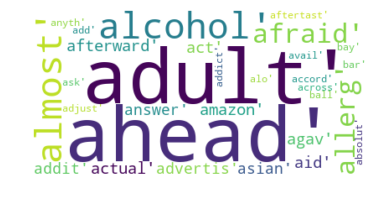

Cluster 22:Word Cloud for KMeans Cluster: 22


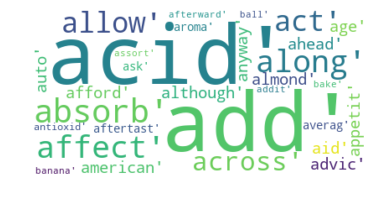

Cluster 23:Word Cloud for KMeans Cluster: 23


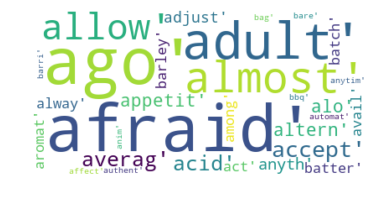

Cluster 24:Word Cloud for KMeans Cluster: 24


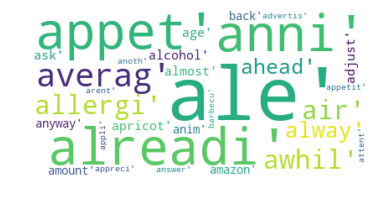

Cluster 25:Word Cloud for KMeans Cluster: 25


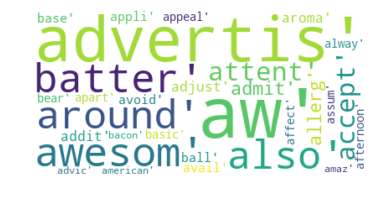

Cluster 26:Word Cloud for KMeans Cluster: 26


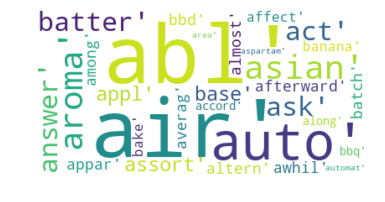

Cluster 27:Word Cloud for KMeans Cluster: 27


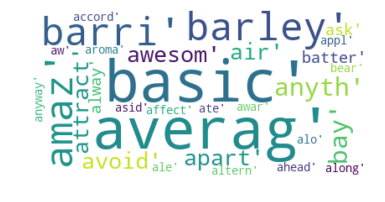

Cluster 28:Word Cloud for KMeans Cluster: 28


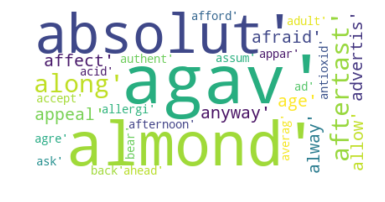

Cluster 29:Word Cloud for KMeans Cluster: 29


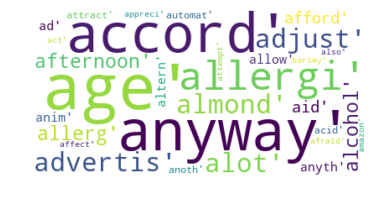

In [56]:
centroids = kmeans_tf.cluster_centers_.argsort() # function for printing top 30 feature names with each cluster

terms = tf_idf_vect.get_feature_names()

list2 = []

for i in range(30):
    print("Cluster %d:" % i, end='')
    for j in centroids[i, :30]:
        list2.append(terms[j])
    wc = WordCloud(background_color="white", max_words=len(str(list2)), stopwords=stopwords_t)
    wc.generate(str(list2))
    print("Word Cloud for KMeans Cluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    list2.clear()

In [58]:
# top 5000 words according to tf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(random_final['CleanedText'].values)


In [ ]:
# pick top 5000 top tf-idf words 
indices1 = np.argsort(tf_idf_vect.idf_)[::-1]
features1 = tf_idf_vect.get_feature_names()

top_n1 = [features1[i] for i in indices1[:5000]]
indices_top1 = np.argsort(top_n1)[::-1]

In [ ]:
n1 = set(top_n1)
f1 = set(features1)
new_set = f1-n1
new_list = list(new_set)
a = np.array((new_list))
D_tr = final_tf_idf.toarray()
for i in range(0, a.size):
    D_tr = np.delete(D_tr, a.shape, axis=1)
    
Sc_tr = sparse.csr_matrix(D_tr)

final_tf_idf = Sc_tr

In [59]:
# shape of tf-idf
final_tf_idf.get_shape()


(10000, 5000)

In [60]:
# Co-occurrence matrix 
final_tf_idf[final_tf_idf > 0] = 1 # to remove word-co-occurrence within each line
final_tf_1 = (final_tf_idf.T * final_tf_idf)
final_tf_1.setdiag(0) # set diagonal elements to be zero as their count will be zero with respect to the same element

In [61]:
final_tf_1   # type of co-occurrence matrix

<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 5493696 stored elements in Compressed Sparse Column format>

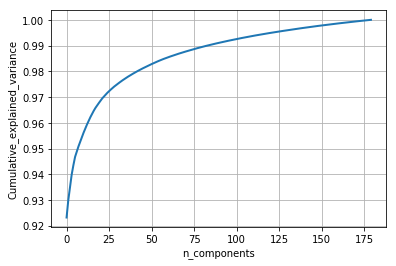

In [62]:
'''
Plotting a CDF on number of components and cumulative_variance_explained to choose the best value of number of components 
such that maximum varince is explained.

'''

from sklearn.decomposition import TruncatedSVD

svd_tf = TruncatedSVD(n_components = 180)
svd_data_tf = svd_tf.fit_transform(final_tf_1)

percentage_var_explained_tf = svd_tf.explained_variance_ / np.sum(svd_tf.explained_variance_);

cum_var_explained_tf = np.cumsum(percentage_var_explained_tf)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained_tf, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# If we take 170-dimensions, approx. 98% of variance is explained.

In [63]:
from sklearn.utils.extmath import randomized_svd

# Matrix factorization X = U Σ V.T
U1, Sigma1, VT1 = randomized_svd(final_tf_1, 
                              n_components=170,
                              n_iter=10,
                              random_state=42)

In [64]:
# Standardizing data with mean=0 and variance = 1 on U1
from sklearn.preprocessing import StandardScaler
standardized_data_tf_idf_kd = StandardScaler(with_mean=False).fit_transform(U1)
print(standardized_data_tf_idf_kd.shape)

(5000, 170)


In [65]:
X_tf_1 = np.array(standardized_data_tf_idf_kd) # storing the values after standardization in a dense array

In [66]:
from sklearn.cluster import KMeans

# applying Kmeans++ on 25 clusters
kmeans_tf_1 = KMeans(n_clusters=25, random_state=42, n_init=30, n_jobs=-1)
kmeans_tf_1.fit(X_tf_1)

    



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=30, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [67]:
kmeans_tf_1.predict(X_tf_1) # labels of clusters

array([7, 3, 7, ..., 7, 7, 7], dtype=int32)

In [68]:
kmeans_tf_1.cluster_centers_ # centers of clusters

array([[ 1.72238192e+00, -8.49234431e-01,  1.18123283e-01, ...,
        -2.78431539e-01, -2.44889045e-01,  2.34462313e-01],
       [ 7.47124001e+00, -1.21797350e+00,  2.95714485e-01, ...,
         1.97723390e+00, -4.83986391e+00, -5.98284766e-02],
       [ 1.29531692e+01,  5.80687206e+00,  1.46253644e-01, ...,
        -1.31898616e+00, -1.02135311e+00,  1.30026174e+00],
       ...,
       [ 6.36991804e+00, -6.03108256e+00,  2.80564725e+00, ...,
        -8.00561835e-01, -3.92346475e-01,  1.28658758e+00],
       [ 1.13217528e+01,  2.33600577e+00, -1.05844935e+01, ...,
        -6.84581864e-01,  4.50620794e-02,  1.84450013e-01],
       [ 1.69527529e+01,  7.58637683e+00, -4.51127126e+01, ...,
        -4.00724519e-01, -6.78841506e-01, -1.85662953e+00]])

Cluster 0:Word Cloud for KMeans Cluster: 0


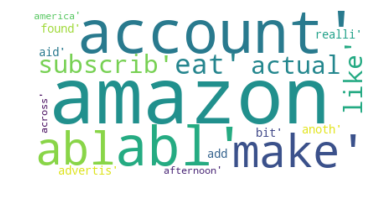

Cluster 1:Word Cloud for KMeans Cluster: 1


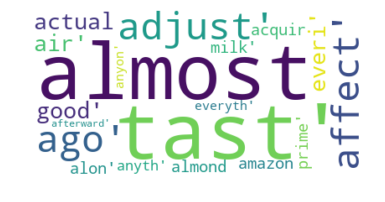

Cluster 2:Word Cloud for KMeans Cluster: 2


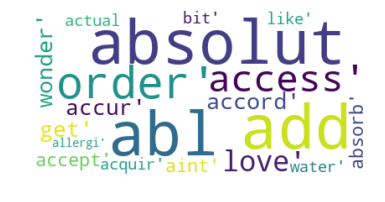

Cluster 3:Word Cloud for KMeans Cluster: 3


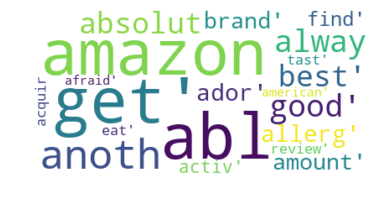

Cluster 4:Word Cloud for KMeans Cluster: 4


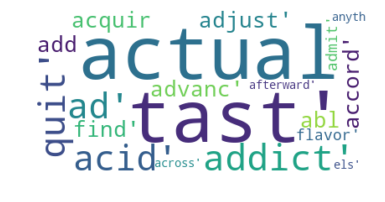

Cluster 5:Word Cloud for KMeans Cluster: 5


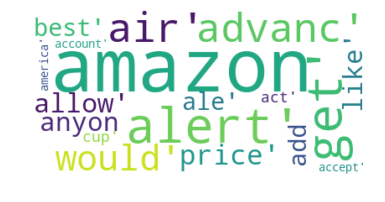

Cluster 6:Word Cloud for KMeans Cluster: 6


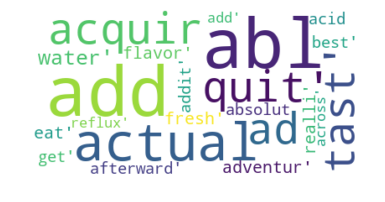

Cluster 7:Word Cloud for KMeans Cluster: 7


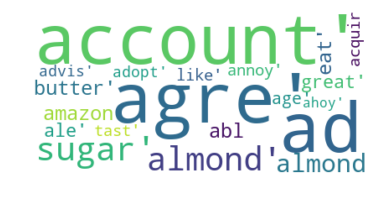

Cluster 8:Word Cloud for KMeans Cluster: 8


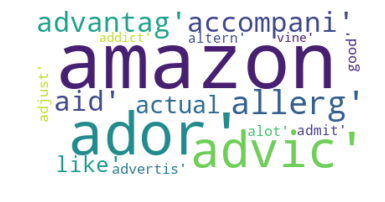

Cluster 9:Word Cloud for KMeans Cluster: 9


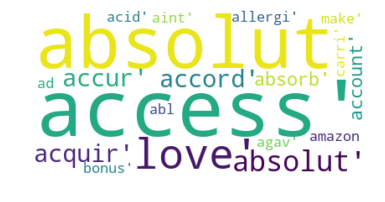

Cluster 10:Word Cloud for KMeans Cluster: 10


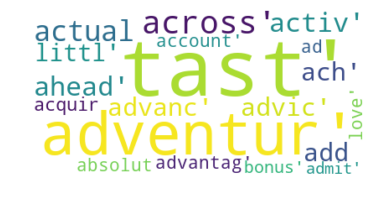

Cluster 11:Word Cloud for KMeans Cluster: 11


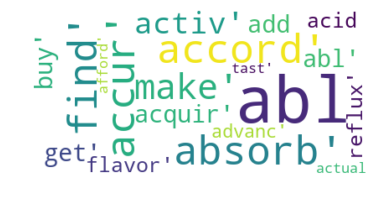

Cluster 12:Word Cloud for KMeans Cluster: 12


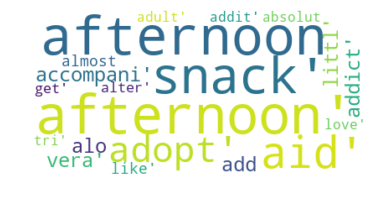

Cluster 13:Word Cloud for KMeans Cluster: 13


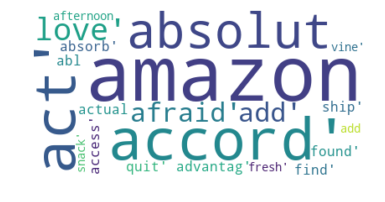

Cluster 14:Word Cloud for KMeans Cluster: 14


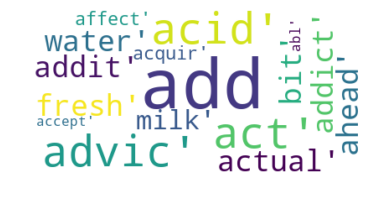

In [69]:
centroids = kmeans_tf_1.cluster_centers_.argsort() # function for printing top 15 feature names with each cluster 

terms = tf_idf_vect.get_feature_names()

list3 = []

for i in range(15):
    print("Cluster %d:" % i, end='')
    for j in centroids[i, :15]:
        list3.append(terms[j])
    wc = WordCloud(background_color="white", max_words=len(str(list3)), stopwords=stopwords_t)
    wc.generate(str(list3))
    print("Word Cloud for KMeans Cluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    list3.clear()

In [70]:
from sklearn.cluster import KMeans

# taking cluster size of 9
kmeans_tf_1 = KMeans(n_clusters=9, random_state=42, n_init=30, n_jobs=-1)
kmeans_tf_1.fit(X_tf_1)

    

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=30, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [71]:
kmeans_tf_1.predict(X_tf_1) # labels of clusters

array([0, 7, 0, ..., 0, 0, 0], dtype=int32)

In [72]:
kmeans_tf_1.cluster_centers_ # centers of clusters

array([[ 3.16159089e-01, -2.13296402e-02,  5.41863683e-03, ...,
         6.85498043e-03,  1.88788666e-02,  3.21335895e-02],
       [ 1.99013328e+00,  9.37007454e-02,  2.21365889e-02, ...,
        -1.48007203e-01, -1.45556858e+00, -1.47249435e+00],
       [ 7.81791471e-01,  6.93690095e-01, -5.74555834e-02, ...,
         3.25998413e-01,  3.13943598e-01, -8.73252006e-01],
       ...,
       [ 9.50873119e+00, -2.17660442e+00,  1.18244809e+00, ...,
         1.73392634e+00,  2.27220108e-02,  6.96379344e-01],
       [ 2.28666825e+00, -3.71349187e-01,  2.96928327e-02, ...,
        -9.96165240e-02, -2.80846233e-01, -1.40405145e-01],
       [ 1.03325536e+01,  3.79701434e+00,  2.92314409e-01, ...,
         7.87522215e-01, -8.79069884e-01,  8.93785159e-01]])

Cluster 0:Word Cloud for KMeans Cluster: 0


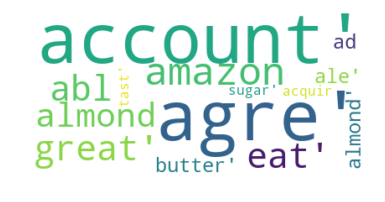

Cluster 1:Word Cloud for KMeans Cluster: 1


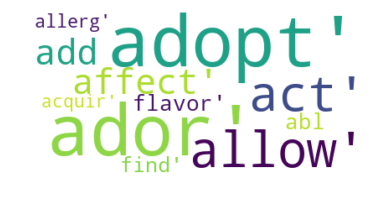

Cluster 2:Word Cloud for KMeans Cluster: 2


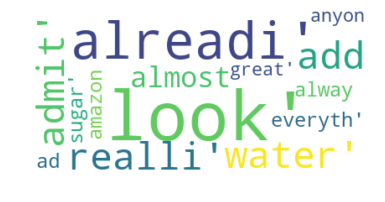

Cluster 3:Word Cloud for KMeans Cluster: 3


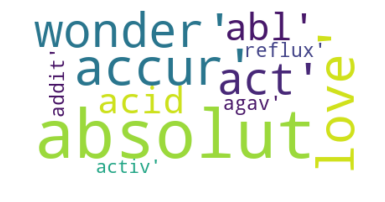

Cluster 4:Word Cloud for KMeans Cluster: 4


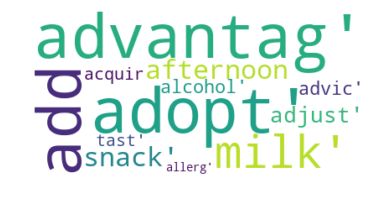

Cluster 5:Word Cloud for KMeans Cluster: 5


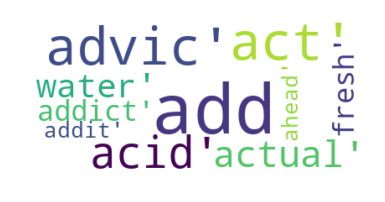

Cluster 6:Word Cloud for KMeans Cluster: 6


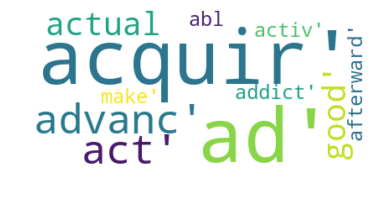

Cluster 7:Word Cloud for KMeans Cluster: 7


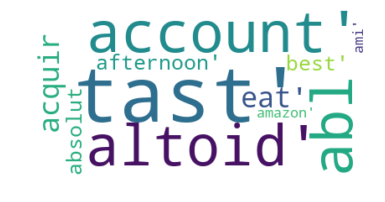

Cluster 8:Word Cloud for KMeans Cluster: 8


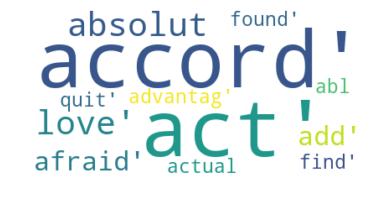

In [74]:
centroids = kmeans_tf_1.cluster_centers_.argsort() # function for printing top 9 feature names with each cluster

terms = tf_idf_vect.get_feature_names()

list4 = []

for i in range(9):
    print("Cluster %d:" % i, end='')
    for j in centroids[i, :9]:
        list4.append(terms[j])
    wc = WordCloud(background_color="white", max_words=len(str(list4)), stopwords=stopwords_t)
    wc.generate(str(list4))
    print("Word Cloud for KMeans Cluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    list4.clear()

In [ ]:
Summary: We first performed data cleaning and removing duplication from the data and then removed the 'Score' attribute 
    from the table. We then applied tf-idf and picked top 2000 words. Then, we constructed a co-occurrence matrix from the 
    top 2000 words and then factorized it using Truncated SVD and found the matrices U,Σ,V as the co-occurrence matrix is
    a square matrix. Then, we standardized our data and then applied K-Means++ on the words of matrix 'U' and then clustered
    with different 'K' and found that they are clustered mainly on taste, flavour an others and plotted WordClouds for each Cluster.
    Then, we repetaed the same steps for 5000 words and did K-means++ clustering after applying Truncated SVD and plotted
    WordCloud for each of the Cluster.
    